<a href="https://colab.research.google.com/github/fboldt/postre/blob/main/aula6b_%C3%81rvores_de_decis%C3%A3o_atributos_cont%C3%ADnuos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Árvore de decisão para atributos contínuos

### Load dataset and get data

In [1]:
# Old Dataset

# from sklearn.datasets import load_iris
# dataset = load_iris()
# X, y = dataset.data, dataset.target

In [35]:
# new Dataset
from sklearn.datasets import load_breast_cancer
dataset = load_breast_cancer()
X, y = dataset.data, dataset.target

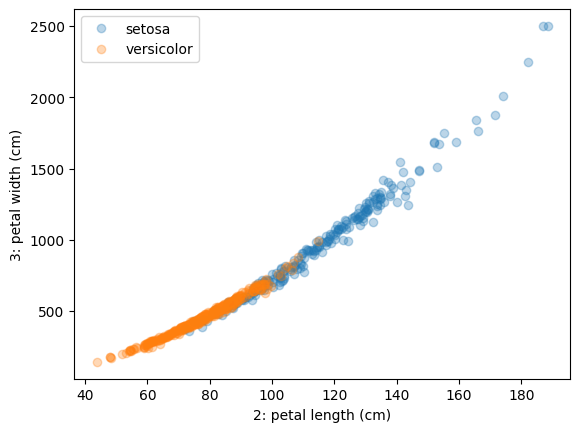

In [36]:
import matplotlib.pyplot as plt
i, j = 2, 3
plt.xlabel(f"{i}: {dataset.feature_names[i]}")
plt.ylabel(f"{j}: {dataset.feature_names[j]}")

for k in set(y):
  plt.plot(X[:,i][y==k], X[:,j][y==k], 'o', alpha=0.3,
           label=f"{dataset.target_names[k]}")
plt.legend()
plt.show()

### ZeroR Example

In [3]:
from sklearn.base import BaseEstimator, ClassifierMixin
from collections import Counter
import numpy as np
from sklearn.model_selection import cross_validate

# Get the most frequent
def maisFrequente(y):
  return Counter(y.flat).most_common(1)[0][0]

class ZeroR(BaseEstimator, ClassifierMixin):
  def fit(self, X, y):
    self.resposta = maisFrequente(y)
    return self
  def predict(self, X, y=None):
    y = np.empty((X.shape[0]))
    y[:] = self.resposta
    return y

scores = cross_validate(ZeroR(), X, y)
scores['test_score'], np.mean(scores['test_score'])

(array([0.33333333, 0.33333333, 0.33333333, 0.33333333, 0.33333333]),
 0.3333333333333333)

In [4]:
modelo = ZeroR()
modelo.fit(X, y)
ypred = modelo.predict(X)
sum(y==ypred)/len(y)

0.3333333333333333

### Tree Example

In [37]:
class Arvore(BaseEstimator, ClassifierMixin):
  def fit(self, X, y):
    self.caracteristica = 2 # Pega o X inteiro
    self.valor = np.mean(X[:,self.caracteristica]) # Pegar a media da caracteristica 2
    maiores = X[:,self.caracteristica] > self.valor # cria um lista com todos os maiores
    if sum(maiores)>0 and sum(~maiores)>0: # Divide a arvore
      self.maiores = Arvore()
      self.maiores.fit(X[maiores,:], y[maiores])
      self.menores = Arvore()
      self.menores.fit(X[~maiores,:], y[~maiores])
    else:
      self.resposta = maisFrequente(y)
    return self
  def predict(self, X, y=None):
    y = np.empty((X.shape[0]))
    if hasattr(self, 'resposta'):
      y[:] = self.resposta
    else:
      maiores = X[:,self.caracteristica] > self.valor
      y[maiores] = self.maiores.predict(X[maiores,:])
      y[~maiores] = self.menores.predict(X[~maiores,:])
    return y

modelo = Arvore()
modelo.fit(X, y)
ypred = modelo.predict(X)
sum(y==ypred)/len(y)

0.9876977152899824

In [38]:
scores = cross_validate(Arvore(), X, y)
scores['test_score'], np.mean(scores['test_score'])

(array([0.8245614 , 0.79824561, 0.85087719, 0.85964912, 0.84070796]),
 0.8348082595870207)

In [39]:
def impureza(y): #Gini
  labels = list(set(y))
  labels.sort()
  probabilidades = np.zeros((len(labels),))
  for i, k in enumerate(labels):
    probabilidades[i] = sum(y==k)/len(y)
  result = 1 - sum(probabilidades ** 2)
  return result

impureza(y[:])

0.4675300607546925

In [40]:
def impurezaValor(x, y, valor):
  maiores = x > valor
  impurezamaiores = impureza(y[maiores])
  proporcaomaiores = sum(maiores)/len(y)
  impurezamenores = impureza(y[~maiores])
  proporcaomenores = sum(~maiores)/len(y)
  impurezaTotal = proporcaomaiores*impurezamaiores + proporcaomenores*impurezamenores
  return impurezaTotal, impurezamenores, impurezamaiores

impurezaValor(X[:,2], y, 2.5)

(0.4675300607546925, 1, 0.4675300607546925)

### Old Code

In [41]:
def melhorValor(x, y):
  result = None
  menorImpureza = float('inf')
  xmax = np.max(x)
  xmin = np.min(x)
  while True:
    valor = (xmin+xmax)/2
    impTotal, impMenores, impMaiores = impurezaValor(x, y, valor)
    if impTotal < menorImpureza:
      menorImpureza = impTotal
      result = valor
      if impMaiores == 0 or impMenores == 0:
        break
      if impMaiores < impMenores:
        xmin = valor
      else:
        xmax = valor
    else:
      break
  return result, menorImpureza

melhorValor(X[:,2], y)

(116.145, 0.30371755118489246)

In [42]:
def melhorCaracteristica(X, y):
  impurezas = []
  valores = []
  for caracteristica in range(X.shape[1]):
    valor, imp = melhorValor(X[:,caracteristica], y)
    impurezas.append(imp)
    valores.append(valor)
  # print(impurezas)
  # print(valores)
  impurezas = np.array(impurezas)
  caracteristica = np.argmin(impurezas)
  return impurezas[caracteristica], caracteristica, valores[caracteristica]

melhorCaracteristica(X, y)

(0.1504971683890802, 27, 0.1455)

In [43]:
class Arvore(BaseEstimator, ClassifierMixin):
  def fit(self, X, y):
    self.impureza, self.caracteristica, self.valor = melhorCaracteristica(X, y)
    maiores = X[:,self.caracteristica] > self.valor
    if sum(maiores)>0 and sum(~maiores)>0:
      self.maiores = Arvore()
      self.maiores.fit(X[maiores,:], y[maiores])
      self.menores = Arvore()
      self.menores.fit(X[~maiores,:], y[~maiores])
    else:
      self.resposta = maisFrequente(y)
    return self
  def predict(self, X, y=None):
    y = np.empty((X.shape[0]))
    if hasattr(self, 'resposta'):
      y[:] = self.resposta
    else:
      maiores = X[:,self.caracteristica] > self.valor
      y[maiores] = self.maiores.predict(X[maiores,:])
      y[~maiores] = self.menores.predict(X[~maiores,:])
    return y

In [44]:
%%timeit

modelo = Arvore()
modelo.fit(X, y)
ypred = modelo.predict(X)
print(sum(y==ypred)/len(y))

scores = cross_validate(Arvore(), X, y)
print(scores['test_score'], np.mean(scores['test_score']))

1.0
[0.92982456 0.86842105 0.94736842 0.93859649 0.91150442] 0.9191429902189101
1.0
[0.92982456 0.86842105 0.94736842 0.93859649 0.91150442] 0.9191429902189101
1.0
[0.92982456 0.86842105 0.94736842 0.93859649 0.91150442] 0.9191429902189101
1.0
[0.92982456 0.86842105 0.94736842 0.93859649 0.91150442] 0.9191429902189101
1.0
[0.92982456 0.86842105 0.94736842 0.93859649 0.91150442] 0.9191429902189101
1.0
[0.92982456 0.86842105 0.94736842 0.93859649 0.91150442] 0.9191429902189101
1.0
[0.92982456 0.86842105 0.94736842 0.93859649 0.91150442] 0.9191429902189101
1.0
[0.92982456 0.86842105 0.94736842 0.93859649 0.91150442] 0.9191429902189101
4.95 s ± 12.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### New Code

In [45]:
def novoMelhorValor(x, y):
  result = None # começa com o resultado vazio
  menorImpureza = float('inf') # Começa com uma impuresa infinita, para que qualquer uma sejá melhor

  # Ordenar os valores de X
  instanciasOrdenadas = np.argsort(x)
  xOrdenado = x[instanciasOrdenadas]

  if len(xOrdenado) == 1:
    # Se há apenas uma instância, retornar o valor e a impureza para esse valor
    return xOrdenado[0], impureza(y)

  for i in range(len(xOrdenado) - 1):
    # Calcular o valor médio entre instâncias consecutivas
    valor = (xOrdenado[i] + xOrdenado[i+1]) / 2

    # Calcular impureza para o valor médio
    impTotal, impMenores, impMaiores = impurezaValor(x, y, valor)

    # Atualizar se a impureza for menor
    if impTotal < menorImpureza:
      menorImpureza = impTotal
      result = valor

      # Verificar se alguma impureza é zero (melhor valor encontrado)
      if impMaiores == 0 or impMenores == 0:
        break
      
  return result, menorImpureza

novoMelhorValor(X[:,2], y)

(45.855000000000004, 0.4670412633976088)

In [46]:
def novaMelhorCaracteristica(X, y):
  impurezas = []
  valores = []
  for caracteristica in range(X.shape[1]):
    valor, imp = novoMelhorValor(X[:,caracteristica], y)
    impurezas.append(imp)
    valores.append(valor)
  # print(impurezas)
  # print(valores)
  impurezas = np.array(impurezas)
  caracteristica = np.argmin(impurezas)
  return impurezas[caracteristica], caracteristica, valores[caracteristica]

novaMelhorCaracteristica(X, y)

(0.46103855053040166, 6, 0.0)

In [47]:
class NovaArvore(BaseEstimator, ClassifierMixin):
  def fit(self, X, y):
    self.impureza, self.caracteristica, self.valor = novaMelhorCaracteristica(X, y)
    
    if isinstance(self.valor, type(None)):
      self.impureza, self.caracteristica, self.valor = novaMelhorCaracteristica(X, y, True)

    maiores = X[:,self.caracteristica] > self.valor
    if sum(maiores)>0 and sum(~maiores)>0:
      self.maiores = Arvore()
      self.maiores.fit(X[maiores,:], y[maiores])
      self.menores = Arvore()
      self.menores.fit(X[~maiores,:], y[~maiores])
    else:
      self.resposta = maisFrequente(y)
    return self
  def predict(self, X, y=None):
    y = np.empty((X.shape[0]))
    if hasattr(self, 'resposta'):
      y[:] = self.resposta
    else:
      maiores = X[:,self.caracteristica] > self.valor
      y[maiores] = self.maiores.predict(X[maiores,:])
      y[~maiores] = self.menores.predict(X[~maiores,:])
    return y

In [48]:
%%timeit

novoModelo = NovaArvore()
novoModelo.fit(X, y)
Nypred = novoModelo.predict(X)
print(sum(y==Nypred)/len(y))

newScores = cross_validate(Arvore(), X, y)
print(newScores['test_score'], np.mean(newScores['test_score']))

1.0
[0.92982456 0.86842105 0.94736842 0.93859649 0.91150442] 0.9191429902189101
1.0
[0.92982456 0.86842105 0.94736842 0.93859649 0.91150442] 0.9191429902189101
1.0
[0.92982456 0.86842105 0.94736842 0.93859649 0.91150442] 0.9191429902189101
1.0
[0.92982456 0.86842105 0.94736842 0.93859649 0.91150442] 0.9191429902189101
1.0
[0.92982456 0.86842105 0.94736842 0.93859649 0.91150442] 0.9191429902189101
1.0
[0.92982456 0.86842105 0.94736842 0.93859649 0.91150442] 0.9191429902189101
1.0
[0.92982456 0.86842105 0.94736842 0.93859649 0.91150442] 0.9191429902189101
1.0
[0.92982456 0.86842105 0.94736842 0.93859649 0.91150442] 0.9191429902189101
5 s ± 20.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Results
---------
Os resultados cos codigos velhos foram:

**Media:** `1.0`

**Cross Validate:** `[0.92982456 0.86842105 0.94736842 0.93859649 0.91150442] 0.9191429902189101`

**Tempo de execução:** `4.95 s ± 12.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)`

--------

Os resultados cos codigos novos foram:

**Media:** `1.0`

**Cross Validate:** `[0.92982456 0.86842105 0.94736842 0.93859649 0.91150442] 0.9191429902189101`

**Tempo de execução:** `5 s ± 20.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)`

-------
Em termos de eficacia os dois codigos demonstão resultados identicos, porem o codigo velho tem um tempo de execução melhor, o que o torna superior neste exemplo.

## Tabelas

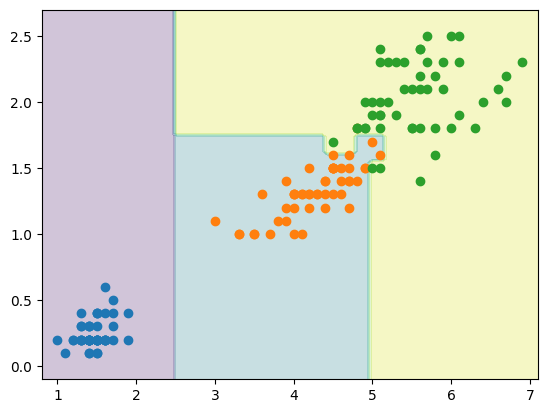

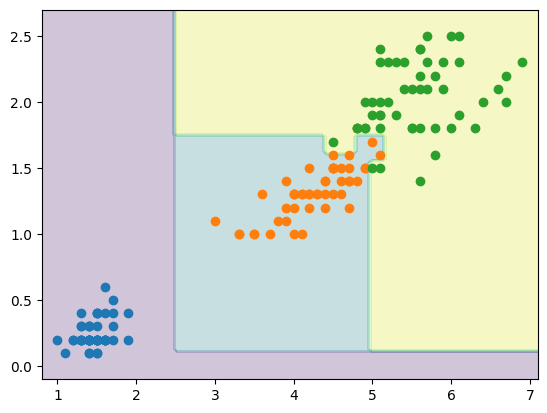

In [21]:
import matplotlib.pyplot as plt

def plotDecisao(modelo, X, y):
  modelo.fit(X, y)
  x0s = np.linspace(np.min(X[:,0])-0.2, np.max(X[:,0])+0.2, 100)
  x1s = np.linspace(np.min(X[:,1])-0.2, np.max(X[:,1])+0.2, 100)
  x0, x1 = np.meshgrid(x0s, x1s)
  Xdec = np.c_[x0.ravel(), x1.ravel()]
  ypred = modelo.predict(Xdec)
  plt.contourf(x0, x1, ypred.reshape(x0.shape), alpha=0.25)
  for k in set(y):
    plt.plot(X[:,0][y==k], X[:,1][y==k], 'o')
  plt.show()

plotDecisao(Arvore(), X[:,2:], y)
plotDecisao(NovaArvore(), X[:,2:], y)

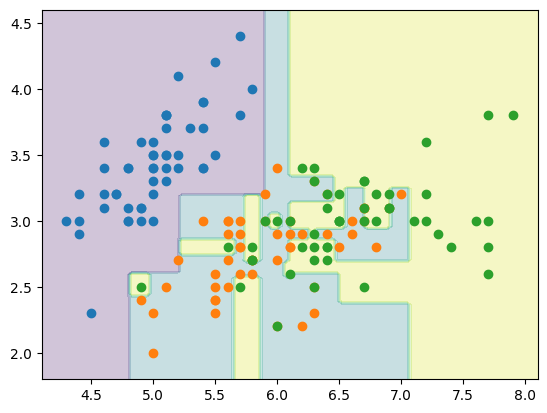

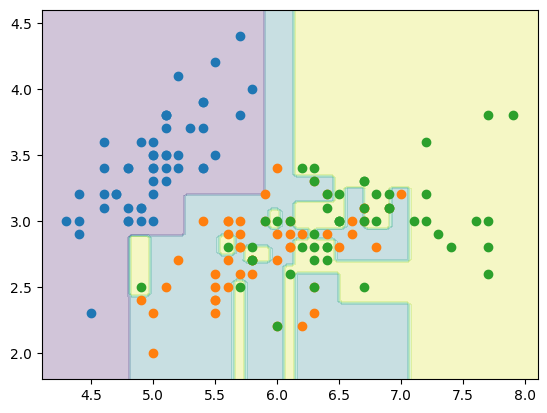

In [22]:
plotDecisao(Arvore(), X[:,:2], y)
plotDecisao(NovaArvore(), X[:,:2], y)

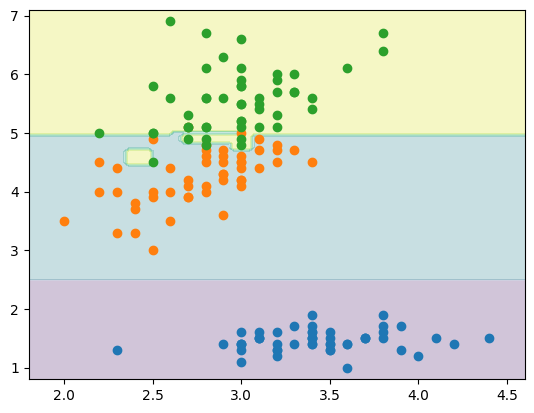

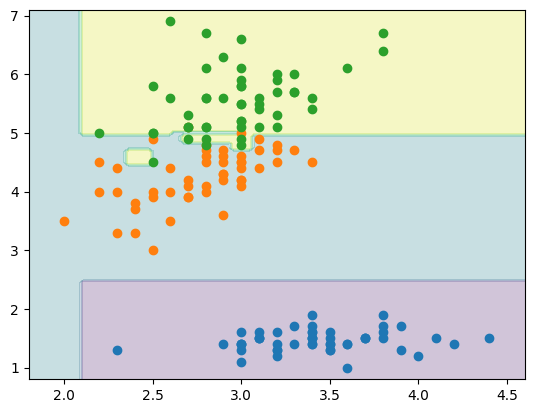

In [23]:
plotDecisao(Arvore(), X[:,1:3], y)
plotDecisao(NovaArvore(), X[:,1:3], y)

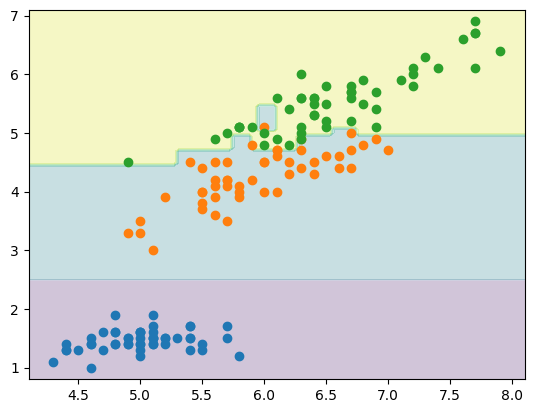

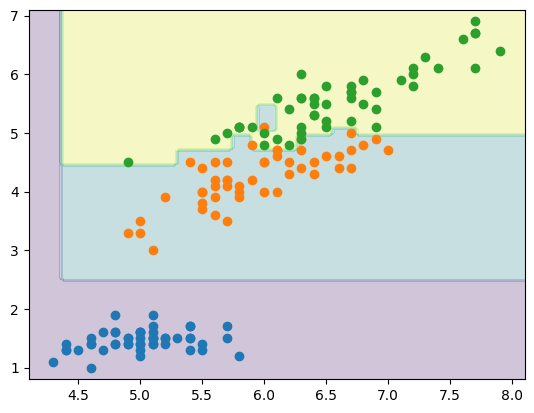

In [24]:
plotDecisao(Arvore(), X[:,[0,2]], y)
plotDecisao(NovaArvore(), X[:,[0,2]], y)

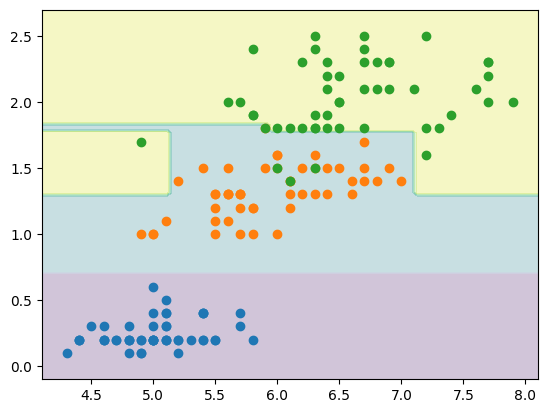

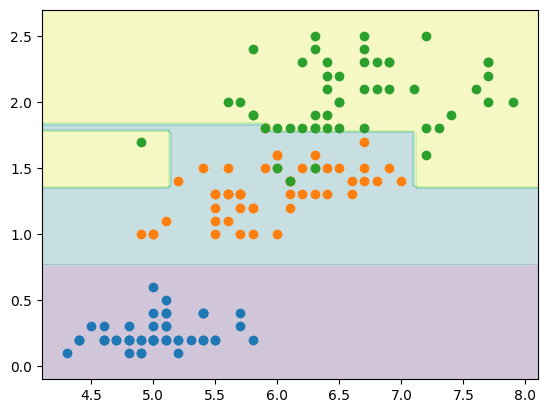

In [25]:
plotDecisao(Arvore(), X[:,[0,3]], y)
plotDecisao(NovaArvore(), X[:,[0,3]], y)

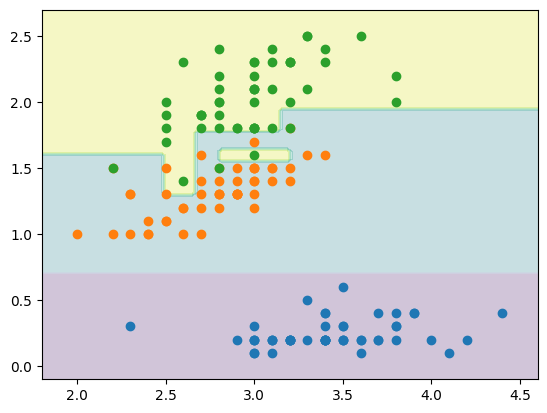

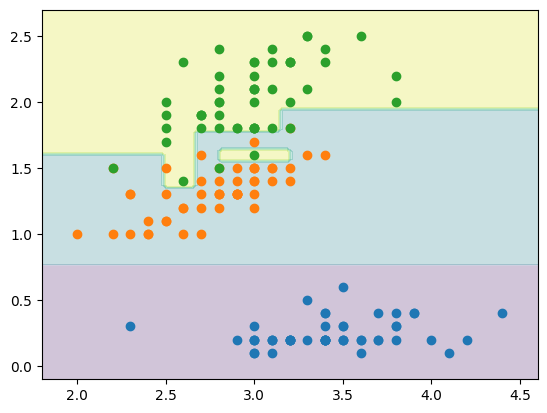

In [26]:
plotDecisao(Arvore(), X[:,[1,3]], y)
plotDecisao(NovaArvore(), X[:,[1,3]], y)

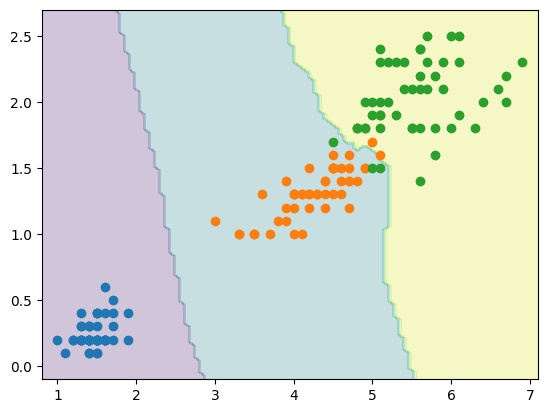

In [27]:
from sklearn.neighbors import KNeighborsClassifier
plotDecisao(KNeighborsClassifier(), X[:,2:], y)

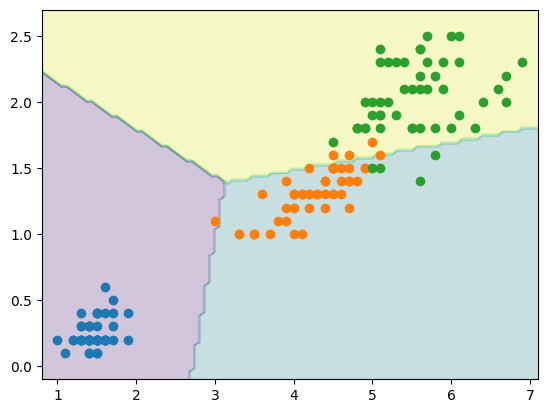

In [28]:
from sklearn.svm import LinearSVC
plotDecisao(LinearSVC(), X[:,2:], y)

C:\Users\arthu\AppData\Roaming\Python\Python311\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


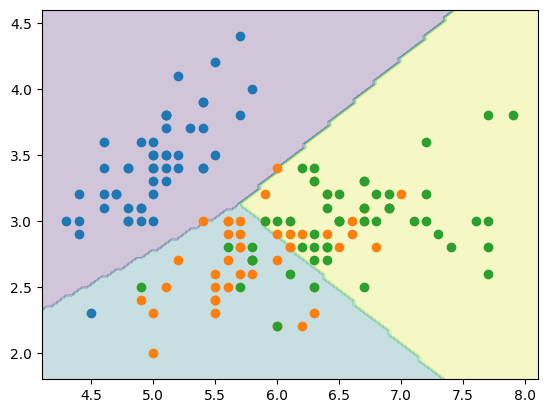

In [29]:
plotDecisao(LinearSVC(), X[:,:2], y)

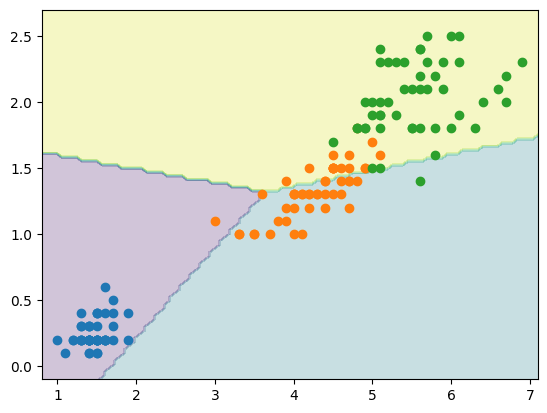

In [30]:
from sklearn.linear_model import Perceptron
plotDecisao(Perceptron(), X[:,2:], y)

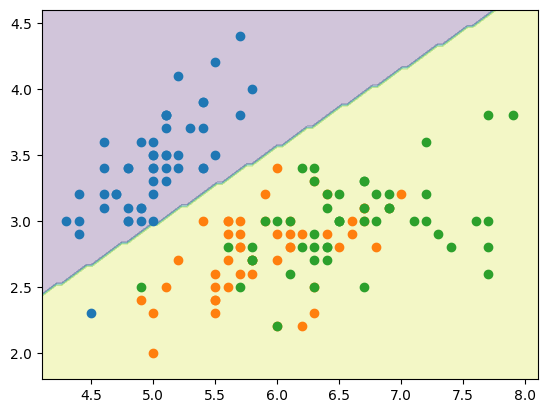

In [31]:
plotDecisao(Perceptron(), X[:,:2], y)